In [21]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
from sys import platform


In [3]:
df1 = pd.read_excel("Data/Web_Teaser_Bewertung_01.xlsx")#, sheet_name=None)

In [4]:
df2 = pd.read_excel("Data/Web_Teaser_Bewertung_02.xlsx")#, sheet_name=None)

In [22]:
df3 = pd.read_excel("Data/Web_Teaser_Bewertung_03.xlsx")#, sheet_name=None)

In [28]:
inputs1, targets1 = split_input_target(df1)
inputs2, targets2 = split_input_target(df2)
inputs3, targets3 = split_input_target(df3)

In [23]:
def split_input_target(df):
    header = df.iloc[0]
    df = df.rename(columns=df.iloc[0]).iloc[1:201]
    if platform == "linux" or platform == "linux2":
        df.drop(columns="teaser_name")
    target_names = ["accent colour", "background colour", "font colour", "font contrast", "space", "roundness"]
    targets = df[target_names]
    inputs = df.drop(columns=target_names)
    inputs = inputs.astype(int)#.abs()
    return inputs, targets

## Check data integrity of target

In [13]:
(targets1 != targets2).sum()

accent colour        53
background colour     1
font colour           0
font contrast         0
space                 0
roundness             8
dtype: int64

In [29]:
mask = (targets1["accent colour"] != targets2["accent colour"])

In [15]:
#targets1[mask]

In [16]:
#targets2[mask]

## Show deviation of responses:

In [24]:
diff = (inputs1 - inputs2).abs()

In [30]:
diff2 = (inputs1 - inputs3).abs()

In [32]:
diff.mean()

Innovative - Traditional       1.850
Elegant - Lassig               1.590
Emotional - Sachlich           1.720
Jung - Erfahren                1.855
Perfektionistisch - Spontan    1.390
zurückhalten - selbstsicher    1.940
Weiblich -  Männlich           2.315
dtype: float64

In [26]:
diff.std()

Innovative - Traditional       2.392933
Elegant - Lassig               1.660024
Emotional - Sachlich           2.259897
Jung - Erfahren                2.735211
Perfektionistisch - Spontan    1.574897
zurückhalten - selbstsicher    2.521545
Weiblich -  Männlich           1.850105
dtype: float64

Text(0.5,1,'Mean deviation of responses with standard deviation')

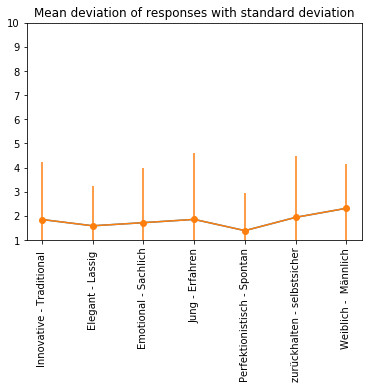

In [27]:
plt.plot(diff.mean())
plt.errorbar(range(len(diff.mean())), diff.mean(),yerr=diff.std(), fmt='-o')
plt.ylim(1,10)
plt.xticks(rotation=90)
plt.title("Mean deviation of responses with standard deviation")

In [35]:
mean = (inputs1 + inputs2 + inputs3)/3
mean

,Innovative - Traditional,Elegant - Lassig,Emotional - Sachlich,Jung - Erfahren,Perfektionistisch - Spontan,zurückhalten - selbstsicher,Weiblich - Männlich
MB_Teaser_01.png,-7.666667,6.666667,-7.333333,-7.666667,7.666667,-5.000000,-5.333333
MB_Teaser_02.png,0.333333,2.333333,-3.000000,-1.333333,5.333333,-3.333333,4.000000
MB_Teaser_03.png,-6.666667,3.000000,-7.000000,-7.333333,8.333333,-2.333333,1.333333
MB_Teaser_04.png,2.000000,-1.666667,3.333333,2.666667,2.000000,-6.000000,1.666667
MB_Teaser_05.png,-4.000000,2.333333,-5.333333,-5.333333,5.333333,-4.000000,-4.000000
MB_Teaser_06.png,6.333333,-5.333333,5.000000,7.333333,0.666667,-6.666667,6.333333
MB_Teaser_07.png,-6.666667,7.666667,-4.666667,-7.666667,7.666667,-2.000000,-1.666667
MB_Teaser_08.png,-5.000000,2.000000,-3.666667,-4.333333,3.666667,-6.333333,-1.000000
MB_Teaser_09.png,-2.000000,2.333333,-1.666667,-4.000000,5.666667,-5.000000,2.666667
MB_Teaser_10.png,7.666667,-5.333333,5.333333,7.000000,-7.333333,-6.666667,6.666667


In [41]:
df4 = mean.mean()
df4

Innovative - Traditional      -0.803333
Elegant - Lassig               1.336667
Emotional - Sachlich          -1.005000
Jung - Erfahren                0.520000
Perfektionistisch - Spontan    1.938333
zurückhalten - selbstsicher   -4.108333
Weiblich -  Männlich           1.186667
dtype: float64

In [39]:
mean.std()

Innovative - Traditional       4.704701
Elegant - Lassig               4.521552
Emotional - Sachlich           3.749480
Jung - Erfahren                4.701074
Perfektionistisch - Spontan    4.459643
zurückhalten - selbstsicher    3.033396
Weiblich -  Männlich           2.600228
dtype: float64